# 3. Nonlinear and multimodal image registration

In this notebook we'll go beyond linear transformations and explore the use of nonlinear transformations for image registration in the context of multimodal images, i.e., images acquired with different modalities.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
import itk
import jupyter_compare_view

Jupyter compare_view v0.2.4


## Load data

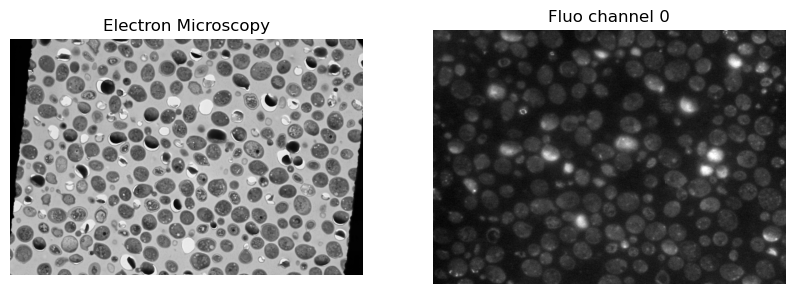

In [2]:
fixed = io.imread("../example_data/em.tif")
moving = io.imread("../example_data/fluo_ch0.tif")

fixed_image_itk = itk.GetImageFromArray(fixed)
moving_image_itk = itk.GetImageFromArray(moving)

# show the images next to each other
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(fixed_image_itk, cmap='gray')
ax[0].set_title('Electron Microscopy')
ax[0].axis('off')
ax[1].imshow(moving_image_itk, cmap='gray')
ax[1].set_title('Fluo channel 0')
ax[1].axis('off')

plt.show()

### Artificially warp the fixed image

To demonstrate the use of nonlinear transformations, we'll start by artificially warping the fixed image. We'll use a random displacement field to warp the fixed image.

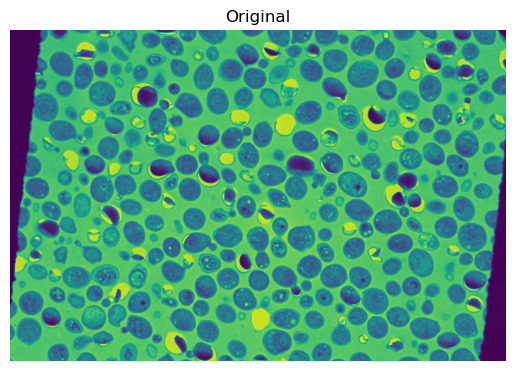

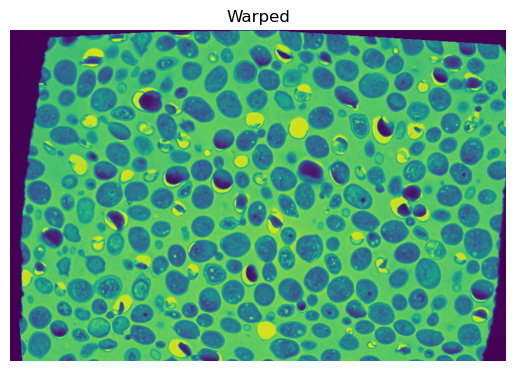

In [3]:
# no need to understand this code block, it just warps the fixed image

from skimage import transform

pt = transform.PiecewiseAffineTransform()
src = np.array(np.meshgrid(np.linspace(0, fixed.shape[1], 5), np.linspace(0, fixed.shape[0], 6))).reshape((2, -1))
np.random.seed(42)
dst = src + np.array([np.random.random(src[0].shape) * 30 for i in range(2)])
pt.estimate(src.T, dst.T)
fixed_warped = transform.warp(fixed, pt.inverse)

plt.figure()
plt.imshow(fixed)
plt.title('Original')
plt.axis(False)
plt.figure()
plt.imshow(fixed_warped)
plt.title('Warped')
plt.axis(False)

fixed_image_itk = itk.GetImageFromArray((fixed_warped * 256).astype(np.uint8))

## Rigid registration

How well does a registration using a linear transformation work?

In [4]:
registration_parameter_object = itk.ParameterObject.New()
registration_parameter_object.AddParameterMap(itk.ParameterObject.New().GetDefaultParameterMap('rigid'))

transformed_moving_image_linear, result_transform_parameters = itk.elastix_registration_method(
    fixed_image_itk,
    moving_image_itk,
    parameter_object=registration_parameter_object,
    log_to_console=False
    )


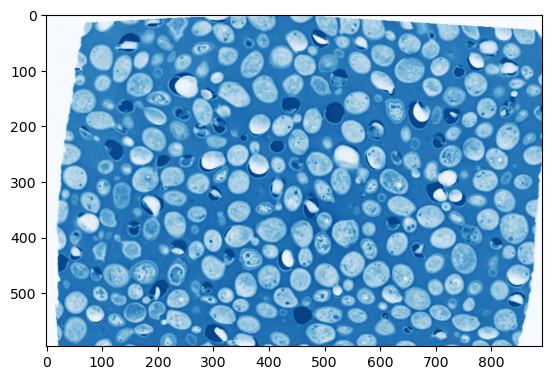
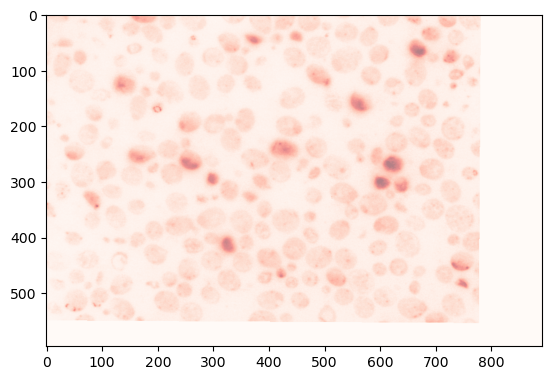

In [5]:
%%compare

plt.figure()
plt.imshow(fixed_image_itk, cmap='Blues')
plt.show()

plt.figure()
plt.imshow(transformed_moving_image_linear, cmap='Reds', alpha=0.5)
plt.show()


## Troubleshooting the registration

The images seem completely off. It seems that the initial linear registration was not able to align the images properly. We'll improve this by manually displacing the fixed image to the left by setting its origin to -100 in the x-axis.

In [6]:
fixed_image_itk.SetOrigin((-100, 0))

transformed_moving_image_linear, result_transform_parameters = itk.elastix_registration_method(
    fixed_image_itk,
    moving_image_itk,
    parameter_object=registration_parameter_object,
    log_to_console=False
    )


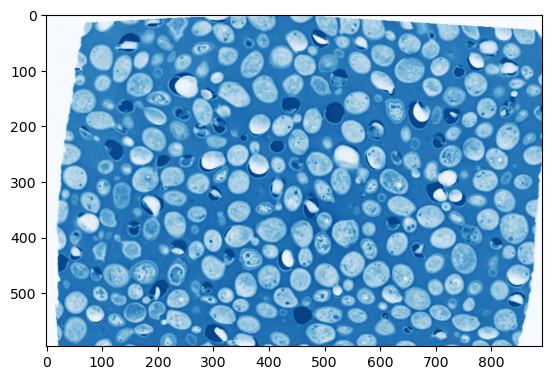
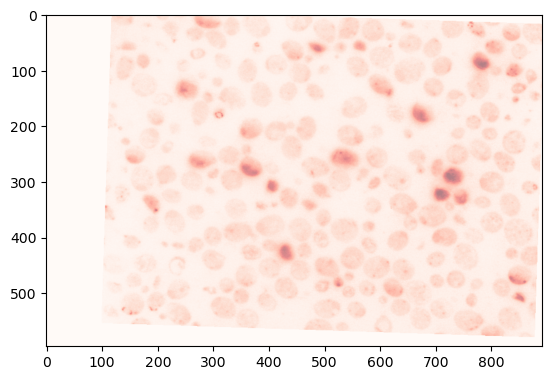

In [7]:
%%compare

plt.figure()
plt.imshow(fixed_image_itk, cmap='Blues')
plt.show()

plt.figure()
plt.imshow(transformed_moving_image_linear, cmap='Reds', alpha=0.5)
plt.show()


## Parameters for nonlinear registration

The nonlinear transformation we'll use is called "B-Spline" transformation. This transformation is based on a grid of control points that are moved to deform the image. The number of control points in each dimension is defined by the parameter `FinalGridSpacingInPhysicalUnits`. The larger the grid size, the more degrees of freedom the transformation has, but also the more prone to registration artefacts it is. Notice the additional metric set in the default parameter map: `TransformBendingPenalty`. This metric is used to regularize the deformation field and avoid unrealistic deformations.

In [8]:
# here we load the default parameter map for bspline (nonlinear) transforms
pmap_bspline = itk.ParameterObject.New().GetDefaultParameterMap('bspline')

# here we choose the grid spacing of the nonlinear transform (in phsyical units, e.g. microns)
pmap_bspline['FinalGridSpacingInPhysicalUnits'] = [str(v) for v in [100] * 2]

# print the default parameter map
pd.DataFrame(
    {'Parameters': pmap_bspline.keys(),
    'Values': pmap_bspline.values()}
    )

,Parameters,Values
0,AutomaticParameterEstimation,"(true,)"
1,CheckNumberOfSamples,"(true,)"
2,DefaultPixelValue,"(0,)"
3,FinalBSplineInterpolationOrder,"(3,)"
4,FinalGridSpacingInPhysicalUnits,"(100, 100)"
5,FixedImagePyramid,"(FixedSmoothingImagePyramid,)"
6,GridSpacingSchedule,"(2.803221, 1.988100, 1.410000, 1.000000)"
7,ImageSampler,"(RandomCoordinate,)"
8,Interpolator,"(LinearInterpolator,)"
9,MaximumNumberOfIterations,"(256,)"


## Multimodal registration

In the same registration run as the nonlinear registration, we'll perform a linear registration to align the images approximately.

In [9]:
registration_parameter_object = itk.ParameterObject.New()

registration_parameter_object.AddParameterMap(itk.ParameterObject.New().GetDefaultParameterMap('rigid'))
registration_parameter_object.AddParameterMap(pmap_bspline)

transformed_moving_image, result_transform_parameters = itk.elastix_registration_method(
    fixed_image_itk,
    moving_image_itk,
    parameter_object=registration_parameter_object,
    log_to_console=False
    )


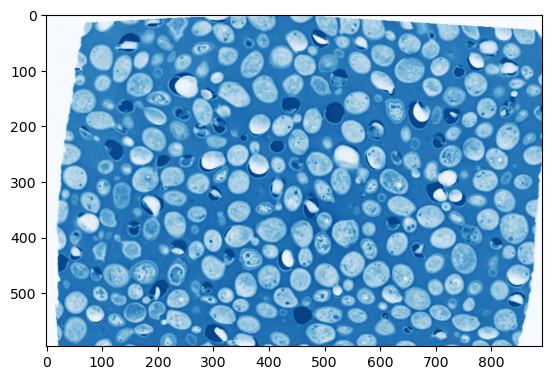
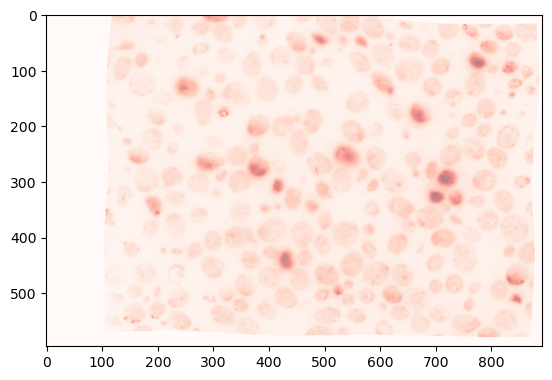

In [10]:
%%compare

plt.figure()
plt.imshow(fixed_image_itk, cmap='Blues')
plt.show()

plt.figure()
plt.imshow(transformed_moving_image, cmap='Reds', alpha=0.5)
plt.show()


## Compare registration results in napari

In [11]:
import napari

def add_itk_image_to_viewer(viewer, image_itk, layer_name, colormap):
    viewer.add_image(
        image_itk,
        translate=fixed_image_itk.GetOrigin(),
        scale=fixed_image_itk.GetSpacing(),
        name=layer_name, colormap=colormap, blending='additive')

viewer = napari.Viewer()

add_itk_image_to_viewer(viewer, fixed_image_itk, 'fixed', 'Grey') 
add_itk_image_to_viewer(viewer, moving_image_itk, 'moving', 'Red') 
add_itk_image_to_viewer(viewer, transformed_moving_image_linear, 'linear', 'Red') 
add_itk_image_to_viewer(viewer, transformed_moving_image, 'nonlinear', 'Red') 


## Exercise: Transformation grid sizes

What happens if you choose different grid sizes for the B-Spline transformation? Experiment with very small (close to pixel size) and very large (close to image extent) grid sizes.

